In [54]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
import glob
import pickle
import ast
import multiprocessing

import sys
sys.path.append('../src')

%load_ext autoreload
%autoreload 1

from datatasks.sample_data import sample_data

from models.EDA import create_ydf
from models.models import evaluate_model
from models.plot import plot_confusion_matrix, plot_LSA, plot_correct_per_publisher
%aimport models.plot

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
DATA_PATH = '../data/'
DATA_INTERIM_PATH = DATA_PATH + 'interim/'
DATA_PROCESSED_PATH = DATA_PATH + 'processed/'

In [3]:
#tagged_documents_train6 = train.iloc[500000:580929].progress_apply(
#    lambda x: TaggedDocument(words=ast.literal_eval(x['tokens']), tags=[x['hyperpartisan']]),
#    axis=1
#)

In [4]:
#with open(DATA_PROCESSED_PATH + "tagged_documents_train6.txt", "wb") as internal_filename:
#    pickle.dump(tagged_documents_train6, internal_filename)

In [25]:
class TrainCorpus(object):
    
    def __init__(self, filepath):
        self.filepath = filepath
        
    def __iter__(self):
        filenames = glob.glob(self.filepath + "tagged_documents_train*")
        filenames.sort()
        for filename in filenames:
            with open(filename, "rb") as internal_filename:
                f = pickle.load(internal_filename)
                for i, line in enumerate(f):

                    if (i % 10000 == 0):
                        logging.info("read {0} docs".format(i))
                    yield line

In [26]:
tagged_documents_train = TrainCorpus(DATA_PROCESSED_PATH)

In [ ]:
doc2vec_model = Doc2Vec(tagged_documents_train, workers=8, vector_size=300, epochs=16, dm=1, min_count=3)

In [29]:
doc2vec_model.save('../model/d2v300')

2018-11-28 12:10:24,578 : INFO : saving Doc2Vec object under ../model/d2v300, separately None
2018-11-28 12:10:24,579 : INFO : storing np array 'syn1neg' to ../model/d2v300.trainables.syn1neg.npy
2018-11-28 12:10:26,153 : INFO : storing np array 'vectors' to ../model/d2v300.wv.vectors.npy
2018-11-28 12:10:28,987 : INFO : saved ../model/d2v300


In [57]:
train = pd.read_csv(DATA_INTERIM_PATH + 'train_p.csv', usecols=['tokens', 'hyperpartisan'])
val = pd.read_csv(DATA_INTERIM_PATH + 'val_p.csv', usecols=['preprocessed_text', 'tokens', 'hyperpartisan', 'domain'])

In [33]:
train_targets, train_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=16)) for doc in tagged_documents_train])

0it [00:00, ?it/s]
  0%|          | 0/6 [00:00<?, ?it/s]2018-11-28 12:13:04,685 : INFO : read 0 docs
9996it [04:55, 45.70it/s]2018-11-28 12:17:00,441 : INFO : read 10000 docs
19995it [08:31, 48.18it/s]2018-11-28 12:20:35,991 : INFO : read 20000 docs
29999it [12:09, 37.98it/s]2018-11-28 12:24:13,816 : INFO : read 30000 docs
39996it [15:51, 36.62it/s]2018-11-28 12:27:56,506 : INFO : read 40000 docs
49996it [19:32, 38.07it/s]2018-11-28 12:31:36,810 : INFO : read 50000 docs
59999it [23:14, 47.67it/s]2018-11-28 12:35:19,397 : INFO : read 60000 docs
69998it [27:02, 48.01it/s]2018-11-28 12:39:06,982 : INFO : read 70000 docs
79998it [30:51, 36.24it/s]2018-11-28 12:42:56,371 : INFO : read 80000 docs
89999it [34:41, 41.16it/s]2018-11-28 12:46:45,537 : INFO : read 90000 docs
99999it [38:34, 28.95it/s]
99999it [38:47, 28.95it/s]2018-11-28 12:51:44,839 : INFO : read 0 docs
109998it [44:33, 51.15it/s]2018-11-28 12:56:37,643 : INFO : read 10000 docs
119997it [48:40, 45.21it/s]2018-11-28 13:00:44,873 

In [36]:
with open(DATA_PROCESSED_PATH + "inferred_doc_vectors_train.txt", "wb") as internal_filename:
    pickle.dump(train_regressors, internal_filename)

In [37]:
with open(DATA_PROCESSED_PATH + "targets_train.txt", "wb") as internal_filename:
    pickle.dump(train_targets, internal_filename)

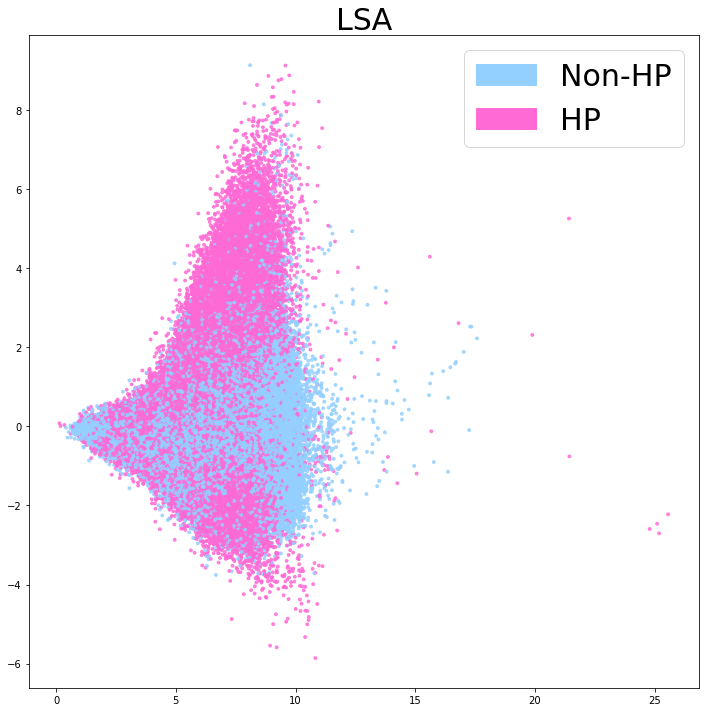

array([[ 4.8514185 , -0.04923661],
       [ 3.9269805 , -0.08776039],
       [ 6.035063  ,  0.31991792],
       ...,
       [ 6.1075954 ,  0.4816991 ],
       [ 5.5150366 , -0.66123664],
       [ 9.331196  , -1.6628683 ]], dtype=float32)

In [38]:
plot_LSA(train_regressors, train_targets)

In [40]:
tqdm.pandas()

In [41]:
tagged_documents_test = val.progress_apply(
    lambda x: TaggedDocument(words=ast.literal_eval(x['tokens']), tags=[x['hyperpartisan']]),
    axis=1
)

100%|██████████| 150000/150000 [08:28<00:00, 295.19it/s]


In [ ]:
with open(DATA_PROCESSED_PATH + "tagged_documents_test.txt", "wb") as internal_filename:
    pickle.dump(tagged_documents_test, internal_filename)

In [45]:
test_targets, test_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=16)) for doc in tqdm(tagged_documents_test.values)])

100%|██████████| 150000/150000 [1:45:51<00:00, 23.62it/s]


In [46]:
with open(DATA_PROCESSED_PATH + "inferred_doc_vectors_test.txt", "wb") as internal_filename:
    pickle.dump(test_regressors, internal_filename)

In [47]:
with open(DATA_PROCESSED_PATH + "targets_test.txt", "wb") as internal_filename:
    pickle.dump(test_targets, internal_filename)

In [48]:
lr = LogisticRegression(n_jobs=-1, random_state=1)
lr = lr.fit(train_regressors, train_targets)

/Users/jmill/anaconda3/envs/SemEval2019-4/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [49]:
predictions = lr.predict(test_regressors)

In [50]:
evaluate_model(test_targets, predictions)

              precision    recall  f1-score   support

       False       0.62      0.40      0.48     75000
        True       0.56      0.76      0.64     75000

   micro avg       0.58      0.58      0.58    150000
   macro avg       0.59      0.58      0.56    150000
weighted avg       0.59      0.58      0.56    150000

Accuracy: 0.5777


0.57766

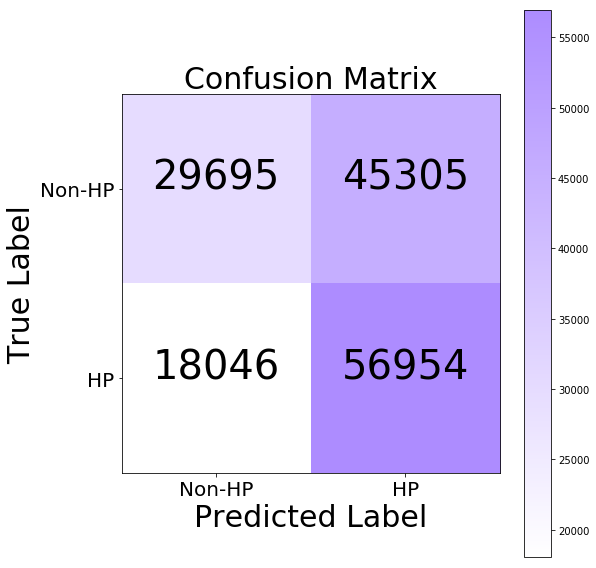

In [51]:
plot_confusion_matrix(test_targets, predictions)

In [58]:
ydf = create_ydf(val, predictions)
%matplotlib tk
plot_correct_per_publisher(ydf, "Base DocVec - Percent Correct per Publisher")